### Sentiment Analysis on Black Friday Reddit posts

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


### VADER Approach

In [2]:
originalPosts = pd.read_csv('combined_blackfriday.csv')
originalPosts = originalPosts.drop(['score','subreddit_id','score'], axis=1)
originalPosts

,retrieved_on,body
0,2018-09-03,mini sale day like black friday cyber monday g...
1,2018-09-05,pretty sure like black friday liquidation sale...
2,2018-09-18,prime times amazon offered one day discount to...
3,2018-09-23,black friday probably
4,2018-09-23,cyber monday prime day also amazon amazing dea...
...,...,...
49304,2022-12-14,blitz used call black friday sales learned ter...
49305,2022-12-14,dispel myth played cool said true wide open pi...
49306,2022-12-14,yup problem capitalism monetary incentive give...
49307,2022-12-14,whole pallet pw crockpots leftover black frida...


In [3]:
def Sentiment_converter(compound):
    if compound >= 0.1:
        return 'Positive'
    elif compound <= -0.1:
        return 'Negative'
    else:
        return 'Neutral'

vader = SentimentIntensityAnalyzer()

for i in range(len(originalPosts)):
    line = originalPosts['body'][i]
    vs = vader.polarity_scores(line)
    originalPosts.loc[i, 'Sentiment'] = Sentiment_converter(vs['compound'])
    originalPosts.loc[i, 'Sentiment_Score'] = (vs['compound'])

originalPosts

,retrieved_on,body,Sentiment,Sentiment_Score
0,2018-09-03,mini sale day like black friday cyber monday g...,Positive,0.9282
1,2018-09-05,pretty sure like black friday liquidation sale...,Positive,0.7184
2,2018-09-18,prime times amazon offered one day discount to...,Positive,0.9729
3,2018-09-23,black friday probably,Neutral,0.0000
4,2018-09-23,cyber monday prime day also amazon amazing dea...,Positive,0.6705
...,...,...,...,...
49304,2022-12-14,blitz used call black friday sales learned ter...,Positive,0.3400
49305,2022-12-14,dispel myth played cool said true wide open pi...,Positive,0.7184
49306,2022-12-14,yup problem capitalism monetary incentive give...,Negative,-0.2500
49307,2022-12-14,whole pallet pw crockpots leftover black frida...,Positive,0.1027


In [4]:
originalPosts['Sentiment'].value_counts()

Sentiment
Positive    26002
Neutral     14746
Negative     8561
Name: count, dtype: int64

### Clustering Approach:

The following is a function that runs K-means on the tf-idf/counts data to cluster the posts into 3 clusters, either positive, negative, or neutural based on word similarity between them. It then uses a pca to reduce the data and plot the cluster representation for visual assesment.

In [55]:
def plot_kmeans_clusters(dataframe, title, num_clusters=3):
    # Standardize the data
    #since k-means is highly sensitive to scale, we need to scale the data before we can use it
    #scaler = StandardScaler()
    #scaled_data = scaler.fit_transform(dataframe)
    scaled_data = dataframe
    # Apply PCA to reduce the data to two dimensions
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)

    # Apply K-Means clustering
    #generate 3 clusters for negative, positive, and neutral sentiments
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    dataframe['cluster'] = kmeans.fit_predict(scaled_data)

    # Plot the clusters
    colors = ['red', 'green', 'blue']

    for cluster_num in range(num_clusters):
        cluster_points = pca_result[dataframe['cluster'] == cluster_num]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_num], label=f'Cluster {cluster_num + 1}')

    plt.title('K-Means Clustering with PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    return dataframe

#### Monograms

I will first compare the performance of monogram TF-IDF v count vectorizers. The reason behind this comparison is to observe and decide which representation of the data offers a better post representation on the plot.

##### Count Vectorizer:

In [23]:
monogram_countVec = pd.read_csv('monograms_count_lemmatized1.csv')

In [30]:
monogram_countVec.drop(['subreddit_id','var_year','score'], axis=1, inplace=True)
monogram_countVec.head()

,aa,aaa,aafes,abandon,ability,able,absence,absolute,absolutely,absurd,...,yrs,yup,z,zelda,zero,zip,zombie,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


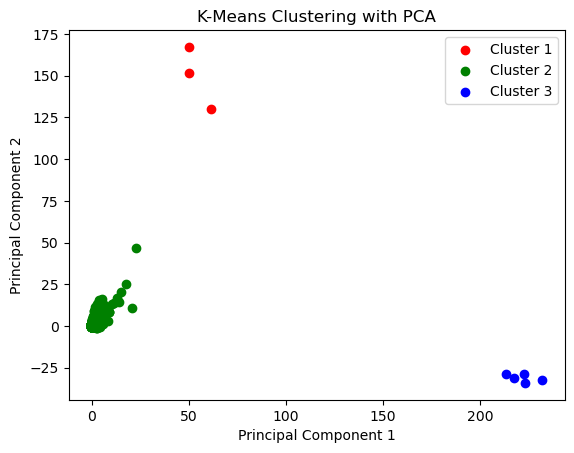

In [60]:
monogram_count = plot_kmeans_clusters(monogram_countVec, 'Monogram Count Vectorizer', num_clusters=3)

In [63]:
monogram_count['cluster'].value_counts()

cluster
1    49301
2        5
0        3
Name: count, dtype: int64

The count vectorizer does not do a good job in representing the posts on the graph, which is one of the reasons why the k-means did not perform well in clustering the posts into sentiments, with nearly all points in one cluster only. Thus, with count vectorizer, the k-means algorithm fails to recognize differences in posts by their word composition.

##### TF-IDF:

In [33]:
monogram_tfidf = pd.read_csv('monograms_count_tfidf_lemmatized.csv')
monogram_tfidf.drop(['subreddit_id','var_year','score'], axis=1, inplace=True)
monogram_tfidf.head()

,aa,aaa,aafes,abandon,ability,able,absence,absolute,absolutely,absurd,...,yr,yrs,yup,z,zelda,zero,zip,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


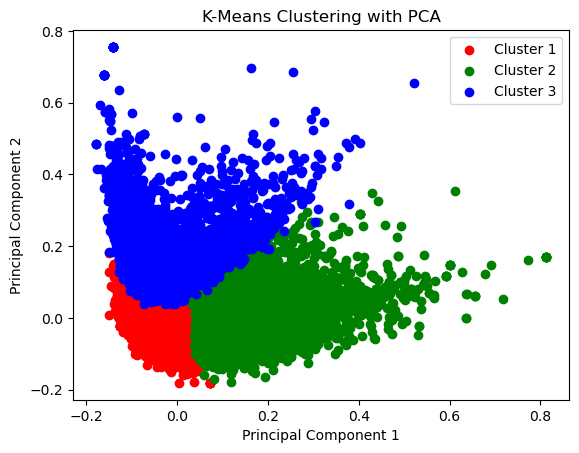

In [61]:
monogram_tf = plot_kmeans_clusters(monogram_tfidf,'Monogram TF-IDF')

In [64]:
monogram_tfidf['cluster'].value_counts()

cluster
0    32313
1    12202
2     4794
Name: count, dtype: int64

The word represntation using TF-IDF allows a substatially better plot representation and segregation on the plot, thus when the k-means was ran, it was able to successfully cluster points into 3 clusters of acceptable size. Therefore, for the rest of the code, I will only rely on TF-IDF representation of words. 

Now, I will compare the similarity of the cluster assignments made by the clustering against that made by Vader.

In [86]:
index = monogram_tfidf[monogram_tfidf['cluster'] == 1].index[0:2]
for i in index:
    print(originalPosts['body'][i])

print("-----------------------------------")
#try new cluster
index = monogram_tfidf[monogram_tfidf['cluster'] == 0].index[0:2]
for i in index:
    print(originalPosts['body'][i])


pretty sure like black friday liquidation sales people go nuts buy things even need want psychologically think afford
black friday probably
-----------------------------------
prime times amazon offered one day discount took advantage expedited shipping discovered movies took advantage noticed shipping took longer two years prime back back movies wanted watch available prime prices everything slowly moving upward learned buying prime spending time watching mediocre movies getting many book reviews done got behind reviews dollar general store came neighborhood right way home work checked realized prices stuff getting via subscribe save much cheaper dollar general oh many cardboard boxes break trips recycling center best deals black friday mother day six months thinking prime monthly basis six months every year travel summer shop much people amazon came prime day july help summer sales miss prime save money plenty good movies watch free tubitv com
tried thursday black friday deals cell p

From the above, I can say that cluster 1 is the neutral posts and cluster 0 is the positive posts, leaving cluster 2 as negative

In [90]:
monogram_tfidf['cluster'] = monogram_tfidf['cluster'].replace({0: 'Positive', 1: 'Neutral', 2: 'Negative'})
similarity = accuracy_score(originalPosts['Sentiment'], monogram_tfidf['cluster'])

print(f'Monogram TF-IDF Clustering Sentiment Similarity with VADER: {similarity * 100:.2f}%')

Monogram TF-IDF Clustering Sentiment Similarity with VADER: 41.24%


#### Bigram

In [107]:
bigrams_tfidf = pd.read_csv('bigrams_count_tfidf_lemmatized.csv')
bigrams_tfidf.drop(['subreddit_id','var_year','score'], axis=1, inplace=True)
bigrams_tfidf.head()

,able buy,able find,able get,able go,able order,able pick,able price,able see,able snag,able use,...,year worth,year would,year year,yes black,yes know,yes use,yes would,yet still,youtube com,zero dawn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


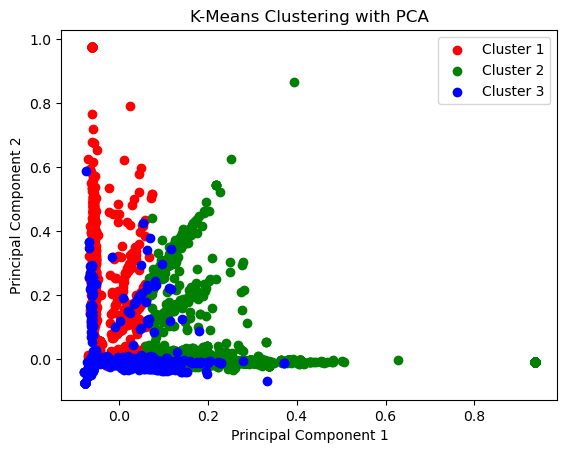

In [108]:
bigrams_tf = plot_kmeans_clusters(bigrams_tfidf, 'Bigram TF-IDF')

In [109]:
bigrams_tf['cluster'].value_counts()

cluster
0    38779
1     8663
2     1867
Name: count, dtype: int64

In [118]:
index = bigrams_tf[bigrams_tf['cluster'] == 1].index[10:13]
for i in index:
    print(originalPosts['body'][i])

print("-----------------------------------")
#try new cluster
index = bigrams_tf[bigrams_tf['cluster'] == 0].index[13:17]
for i in index:
    print(originalPosts['body'][i])


black friday deals hosting providers seo tools really good
think taxact black friday deal
black friday deals absolute garbage lmao rack price big day sell price originally
-----------------------------------
completely chance like prime day started wanted see deal one since missed one black friday notice cameras completely choked immediately started prime trial bought bundle
like black friday advertise retail price discounted price people look actual price randomly times year thing really wanted fire stick
bookshelf weighted blanket books going buy dad bed regret sure would like also wanted camera computer think might wait black friday
happened last year black friday issued refund order stuff regular price received stuff contact refunded price difference reason could refund price difference received product


Looking at the cluster compositions and the posts above, it is very hard to tell which cluster is for which sentiment; this gives evidence that k-means with bigrams is not performing well, thus I will not use it.

#### Trigram

In [43]:
trigram_tfidf = pd.read_csv('trigrams_count_tfidf_lemmatized.csv')
trigram_tfidf.drop(['subreddit_id','var_year','score'], axis=1, inplace=True)
trigram_tfidf.head()

,able add cart,able find anything,able get away,able get deal,able get one,able get price,able order one,able place order,able price match,able share information,...,year work retail,year work thanksgiving,year year ago,year year year,yes best buy,yes black friday,yesterday black friday,youtu http youtu,youtube com watch,zelda breath wild
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


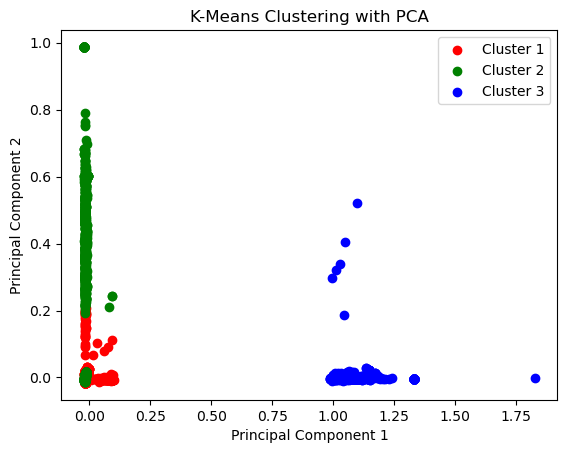

In [91]:
trigram_tf = plot_kmeans_clusters(trigram_tfidf, 'Trigram TF-IDF')

In [92]:
trigram_tf['cluster'].value_counts()

cluster
0    47356
1     1258
2      695
Name: count, dtype: int64

Looking at the cluster compositions, it is clear to observe that k-means is not performing well with trigrams, thus no further experimenation with trigrams will be made.

#### (1:3)

In [110]:
grams_tfidf = pd.read_csv("one_three_grams_count_tfidf_lemmatized.csv")
grams_tfidf.drop(['subreddit_id','var_year','score'], axis=1, inplace=True)


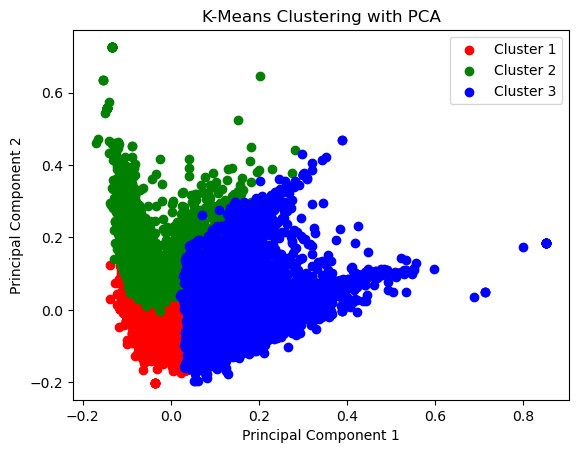

In [111]:
grams_tf = plot_kmeans_clusters(grams_tfidf, 'One to Three Grams TF-IDF')

In [112]:
grams_tf['cluster'].value_counts()

cluster
0    31979
2    12929
1     4401
Name: count, dtype: int64

In [142]:
index = grams_tf[grams_tf['cluster'] == 0].index[3:6]
for i in index:
    print(originalPosts['body'][i])

print("-----------------------------------")
#try new cluster
index = grams_tf[grams_tf['cluster'] == 1].index[10:14]
for i in index:
    print(originalPosts['body'][i])


understand people liking amazon think long term view amazon appreciated short view day shipping yes utterly amazing fast amazon compared anyone else country think people appreciate crunch days like cyber monday christmas etc view day shipping realize sometimes physically cannot achieve times day shipping sooner good day shipping something ordered always amazes many people get incredibly amazing service bad times everything done discredited useless company amp want say generation entitlement older guy always loved ordering online amazon literally god like world shipping remember ordering things like mugs mice waiting weeks years later people flipping amazon hours late usps delivery think need look long term benefits amazing things amazon prime gives day shipping almost tons music prime reading stuff audible photo storage free twitch prime spend anyone want got amazon prime card get cash back access lightning deals plus prime video everything ordered something cyber monday showed get day

In [152]:
grams_tf['cluster'] = grams_tf['cluster'].replace({0: 'Positive', 1: 'Neutral', 2: 'Negative'})
similarity = accuracy_score(originalPosts['Sentiment'], grams_tf['cluster'])
print(f'One to Three Grams TF-IDF Clustering Sentiment Similarity with VADER: {similarity * 100:.2f}%')

One to Three Grams TF-IDF Clustering Sentiment Similarity with VADER: 42.14%


The One to Three grams TF-IDF has a similiarity of 42.14% with the VADER algorithm, which is the highest of all (monogram, bigram, trigram, and (1:3)). Thus, I will be using the (1:3) k-means cluster labels to continue the analysis.

### Choosing the Model

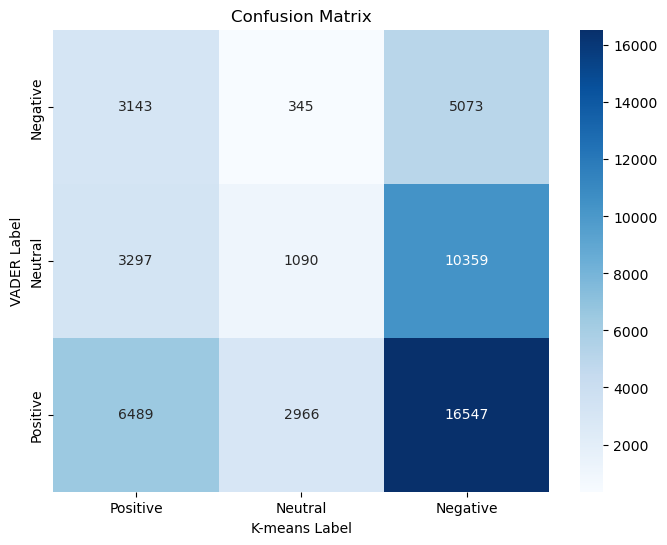

In [153]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(originalPosts['Sentiment'], grams_tf['cluster'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', yticklabels=['Negative', 'Neutral', 'Positive'],xticklabels=['Positive', 'Neutral', 'Negative'])
plt.xlabel('K-means Label')
plt.ylabel('VADER Label')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix, we can see that most of the dissimilarities in classification happens in cases where k-means predicts negative while the VADER predicts positive or Neutral. The dissimilarity in just the negative class contributes to about 50% of the dissimilarity between both models. Thus, I will do a manual check to compare about 10 posts that are classified as negative by K-means, against what VADER classifies them. Accordingly, I will take the decision on which model's sentiment I will use.

In [156]:
count = 0
for i in range(len(grams_tf)):
    if grams_tf['cluster'][i] != originalPosts['Sentiment'][i] and grams_tf['cluster'][i] == 'Negative':
        print("K-Means: ", grams_tf['cluster'][i])
        print("VADER: ",originalPosts['Sentiment'][i])
        print(originalPosts['body'][i])
        print('-----------------------------------')
        if count == 10:
            break
        count += 1

K-Means:  Negative
VADER:  Positive
pretty sure like black friday liquidation sales people go nuts buy things even need want psychologically think afford
-----------------------------------
K-Means:  Negative
VADER:  Neutral
black friday probably
-----------------------------------
K-Means:  Negative
VADER:  Positive
question guess especially black friday cyber monday seems like want new stuff buying gifts stuff buying
-----------------------------------
K-Means:  Negative
VADER:  Positive
ordered two slamballs black friday originally scheduled arrive monday delayed tuesday despite order tracker saying delivery monday okay though black friday crazy shipping time amazon accurate shipping commitments time get pay free two day shipping one day delay blue moon within tolerance
-----------------------------------
K-Means:  Negative
VADER:  Positive
someone orders amazon min twice week say year pretty timely past week orders started taking bit longer process ship arrive expected around holid

Looking at this sample of comments, I can see that the VADER labels are generally more representitive of the actual sentiment of the comments, thus I will use the vader sentiments as the final sentiments for the next steps.

In [5]:
originalPosts.to_csv('Vader_Posts_sentiment.csv')